# 1. Import libraries and files

In [1]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
from catboost import CatBoostRegressor

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime


# import from previous notebook
import nbimporter
import Model10_four_models as FourModels

# import model
import pickle
import lightgbm
import os
import joblib

# import constants
import config

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# >> enter the model we want to plot here
MODEL_NAME = "catboost_base"
# <<<<<<


# 2. Plot class

In [3]:
class Plot():
    def __init__(self):
        """pass"""
        # 1. reformat date index for plotting
        self.format_before = '%Y-%m-%d %H:%M:%S'
        self.format_after = '%H:%M'
                
    def plot(self,
             df_bldg,
             scene_name, 
             output_path="",
             is_save=False):
        
        """"A function that plot prediction and scenario or actual values of a single bldg. 
        Will save the images to output path if is_save is set to true"""
     
        # 1. grab plot name from the column
        predicted_plot_name = df_bldg.columns[1]
        actual_plot_name = df_bldg.columns[2]

        # 2. reformat
        df_bldg.index = pd.to_datetime(df_bldg.index, 
                                    format = self.format_before).strftime(self.format_after)
        # 3. get bldgname
        bldgname = df_bldg["bldgname"][0]

        # 4. compute the difference
        # (predicted - actual) / actual
        avg_diff = round(((df_bldg[predicted_plot_name].mean() - 
                df_bldg[actual_plot_name].mean())/df_bldg[actual_plot_name].mean())*100, 2) 
        
        # 5. Create first plot.
        ax = df_bldg.plot(
            y = predicted_plot_name, 
            label = predicted_plot_name,
            ylabel = config.CHWTON, 
            title = scene_name + " " + bldgname + "[avg diff= " + str(avg_diff) + "%]")

        # 6. second plot: actual
        df_bldg.plot(y = actual_plot_name, 
                     label = actual_plot_name, 
                     ax=ax)


        # 7. save the image
        if is_save:
            # "./result/<model name>/<scene name>/"
            save_path = output_path +"/" + scene_name + "/"
            isExist = os.path.exists(save_path)
            if not isExist:
               # Create a new directory because it does not exist
               os.makedirs(save_path)

            fig = ax.get_figure()
            fig.savefig(save_path + bldgname +'_' + scene_name + '.png')
            
                


# 4. Scoring Class

In [4]:
class Scoring():
    def __init__(self):
        # create df to store scores per bldg
        columns=['model',
                 'bldgname', 
                 "r2_val", 
                 'r2', 
                 "mae",
                 "mape",
                 "mse",
                 'rmse',
                 'mbe']

        self.df_scores= pd.DataFrame()
        self.combined_name = "combined"
        self.format_5f = "{0:.5f}"
        self.format_7f = "{0:.7f}"
        
    def get_df_scores(self):
        return self.df_scores
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe
    
    def compute_all_metrics(self, df, model_name):
        
        # 0. set bldgname:
        # check if its all bldg or a single bldg
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get all scores
        r2 = r2_score(y_actual, y_pred)
        mae = mean_absolute_error(y_actual, y_pred)
        mape = mean_absolute_percentage_error(y_actual, y_pred)
        mse = mean_squared_error(y_actual, y_pred)
        rmse = math.sqrt(mse)
        mbe = self.get_MBE(y_actual, y_pred)
        
        # 3. append score
        # - scores_df to display the scores for all our models
        new_row_data = {'model': model_name, 
                        "bldgname": bldgname, 
                        "r2_val": 0,
                        "r2": self.format_5f.format(r2), 
                        "mae": self.format_5f.format(mae),
                        "mape": self.format_5f.format(mape),
                        "mse": self.format_7f.format(mse),
                        'rmse': self.format_5f.format(rmse), 
                        'mbe': self.format_5f.format(mbe)
                       }
        
        new_row = pd.DataFrame.from_records([new_row_data])
        self.df_scores = pd.concat([self.df_scores, new_row])
        
        
    def compute_r2_val(self, df, model_name):
        
        # 0. set bldgname
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get r2
        r2 = r2_score(y_actual, y_pred)
        self.df_scores.loc[self.df_scores['bldgname']== bldgname, 'r2_val'] = self.format_5f.format(r2)


    def save_scores_csv(self, output_dir_path, model_name):
        self.df_scores.to_csv(output_dir_path + '/metrics_' + model_name + '.csv', index=False)
    

# 5. Import Data and Model

In [5]:
# 1. Load data
data_obj = FourModels.Data(config.TRAIN_FILE_PATH, config.TEST_FILE_PATH)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test= data_obj.get_xy_test()

# 2. Load Model
model_file_path = config.MODEL_DIR_PATH +"/"+ MODEL_NAME + ".sav"
if "lgbm" in MODEL_NAME:
    print("model path=", config.MODEL_DIR_PATH)
    model = joblib.load(config.MODEL_DIR_PATH)

else:
    model = pickle.load(open(model_file_path, 'rb'))

    
# 3. test and confirm correct score
tt = FourModels.TrainTest(X_train_val, y_train_val, X_test, y_test)
tt.test_and_store_score(model, MODEL_NAME)
scores_all = tt.get_scores_df()
print(scores_all)


final X train val= Index(['KW', 'KW/SQM', 'HTmmBTU', 'HTmmBTU/SQM', 'AirT_North', 'AirT_East',
       'AirT_South', 'AirT_West', 'AirT_Mean', 'RelH_Mean', 'AbsH_Mean',
       'ShortW_North', 'ShortW_East', 'ShortW_South', 'ShortW_West',
       'ShortW_Top', 'LongW_North', 'LongW_East', 'LongW_South', 'LongW_West',
       'LongW_Top', 'Shade_North', 'Shade_East', 'Shade_South', 'Shade_West',
       'Shade_Top', 'Area_North', 'Area_East', 'Area_South', 'Area_West',
       'Area_Top', 'bldgname_ISTB 4', 'bldgname_Psychology North',
       'bldgname_Psychology', 'SumW_Top', 'SumW_East', 'SumW_South',
       'SumW_West', 'SumW_North'],
      dtype='object')
test_score: r2=0.9309069025111804, rmse=0.0016022498826625407, mbe=-0.00069248862042891
           model r2_val   r2_test  rmse_test  mbe_test  train_time_s
0  catboost_base      0  0.930907   0.001602 -0.000692           0.0


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


# 5. Prediction VS Actual

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


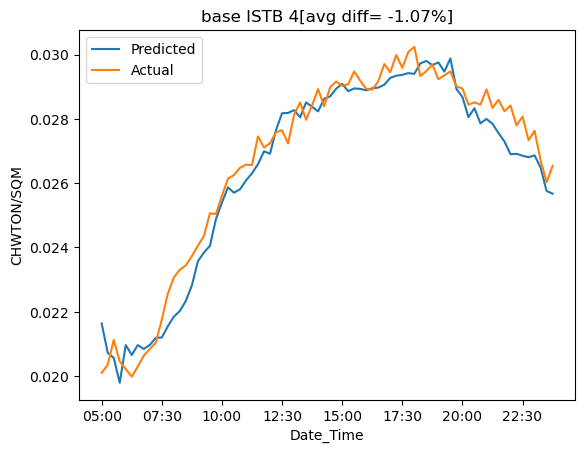

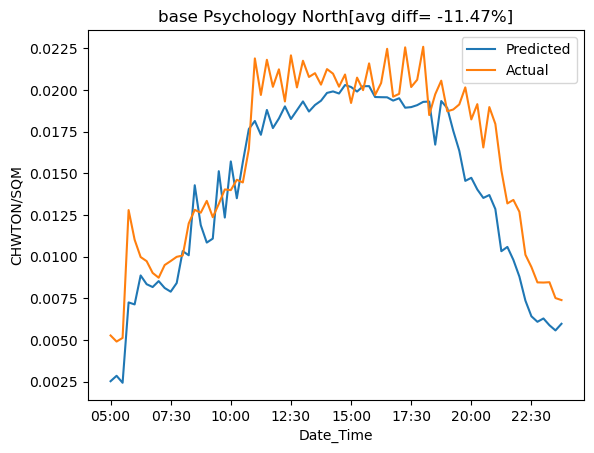

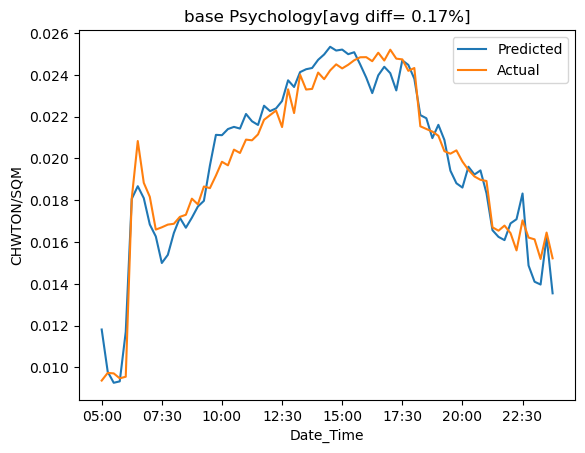

In [28]:
# 1. predict test data and create df_bldgs
y_pred = model.predict(X_test)
df_combined_test, df_bldgs_test = data_obj.create_df_bldgs(y_pred, y_test)

# 2. plot
plt_obj = Plot()
for df_bldg in df_bldgs_test:
    plt_obj.plot(df_bldg, 
                 "base", 
                 output_path=f"{config.RESULT_DIR_PATH}/{MODEL_NAME}", 
                 is_save=True)
    


In [29]:
# 3. Predict training data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                      y_train_val, 
                                                      test_size=0.3, 
                                                      random_state=20)
y_pred_val = model.predict(X_val)
df_combined_val, df_bldgs_val = data_obj.create_df_bldgs(y_pred_val,
                                                         y_val, 
                                                         is_val=True)


## Get scores for each bldg

In [30]:
# 1. init scoring object
scoring_obj = Scoring()

# 2. compute scores for each bldg
for df_bldg in df_bldgs_test:
    scoring_obj.compute_all_metrics(df_bldg, MODEL_NAME)
    
for df_bldg in df_bldgs_val:
    scoring_obj.compute_r2_val(df_bldg, MODEL_NAME)
    
    
# # 3. compute scores combined
scoring_obj.compute_all_metrics(df_combined_test, MODEL_NAME)
scoring_obj.compute_r2_val(df_combined_val, MODEL_NAME)

# # 4. grab result
df_scores = scoring_obj.get_df_scores()
df_scores

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.98779' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,model,bldgname,r2_val,r2,mae,mape,mse,rmse,mbe
0,catboost_base,ISTB 4,0.98779,0.95712,0.00052,0.02015,0.0000004,0.00063,-0.00029
0,catboost_base,Psychology North,0.96410,0.76547,0.00209,0.15258,0.0000063,0.00250,-0.00182
0,catboost_base,Psychology,0.94104,0.93445,0.00084,0.04635,0.0000011,0.00103,0.00003
0,catboost_base,combined,0.97928,0.93091,0.00115,0.07303,0.0000026,0.00160,-0.00069


In [31]:
scoring_obj.save_scores_csv(config.RESULT_DIR_PATH, MODEL_NAME)

# 6. Scenario VS Actual Data Preparation.

Make the model predict the CHWTON for July 7th on the scenario data.
Compare this with the actual CHWTON for non scenario data.

In [32]:
scenario_date = '2023-07-07'

# Determine which columns we want to keep for X_test
final_cols = ['KW', 'HTmmBTU',
              'AirT_Mean', 'AbsH_Mean',
              'AirT_North', 'AirT_East', 'AirT_South', 'AirT_West',
              'ShortW_North', 'ShortW_East', 'ShortW_South', 'ShortW_West', 'ShortW_Top',
              'Shade_North', 'Shade_East', 'Shade_South', 'Shade_West', 'Shade_Top',
              'Area_North', 'Area_East', 'Area_South', 'Area_West', 'Area_Top',
              'SumW_East', 'SumW_South','SumW_West', 'SumW_North', 'SumW_Top',
              'bldgname_ISTB 4', 'bldgname_Psychology North', 'bldgname_Psychology',
              'CHWTON/SQM', 
              ]

def filter_df(df, final_cols, test_date):
    """
    Function to filter the data frame to drop all columns apart from that in `final_cols`.
    Also exclude all data with dates outisde of `test_date`.
    """
    # Filter date.
    # Set the 'Date_Time' column as the index of the DataFrame.
    df[config.DATE_TIME] = pd.to_datetime(df[config.DATE_TIME])

    # Only get data on test_date.
    date_filter = df[config.DATE_TIME].dt.date == pd.to_datetime(scenario_date).date()
    df = df[date_filter]
    df.set_index(config.DATE_TIME, inplace=True)

    # Drop cols that are not in final_cols:
    cols_to_drop = [col for col in df.columns if col not in final_cols]

    return df.drop(columns=cols_to_drop)



## 6.1 Get Scenario Data.

In [33]:
# scenario_dir_path = config.TREES_EXTREME_DIR_PATH
# scenario_dir_path = config.HIGH_ALBEDO_WALLS_DIR_PATH
# scenario_dir_path = config.COOL_PAVEMENT_DIR_PATH
# scenario_dir_path = config.WALL_SHADE_DIR_PATH
# scenario_dir_path = config.TREES_SURROUND_DIR_PATH
# scenario_dir_path = config.PV_ROOFTOP_DIR_PATH
# scenario_dir_path = config.PV_ROOFTOP_TREES_DIR_PATH
scenario_dir_path = config.PV_SIDEWALKS_DIR_PATH
scenario_name = scenario_dir_path.split('/')[-1]

# Create combine csv files from the separate building data for scenarios.
FourModels.combine_csv(scenario_dir_path, config.THREE_BLDGS_FILENAME)

# Load scenario dataframe.
three_bldgs_scenario_df = pd.read_csv(f"{scenario_dir_path}/{config.THREE_BLDGS_FILENAME}.csv")
three_bldgs_scenario_df = filter_df(three_bldgs_scenario_df, final_cols, scenario_date)
X_scenario = three_bldgs_scenario_df.drop(columns=[config.CHWTON])


loading from....: ../data/microclimate_model/combined/dataset2/scenarios/pv_sidewalks/Psychology_North.csv
loading from....: ../data/microclimate_model/combined/dataset2/scenarios/pv_sidewalks/Istb_4.csv
loading from....: ../data/microclimate_model/combined/dataset2/scenarios/pv_sidewalks/Psychology.csv


## 6.1. Get Actual Data.

In [34]:
three_bldgs_actual_df = pd.read_csv(f"{config.BASE_PATH}/{config.THREE_BLDGS_FILENAME}.csv")
three_bldgs_actual_df = filter_df(three_bldgs_actual_df, final_cols, scenario_date)
y_actual = three_bldgs_actual_df[config.CHWTON]

# 7. Plot Air Temp Scenario Prediction

In [35]:
# 1. make prediction 
y_scenario = model.predict(X_scenario)



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


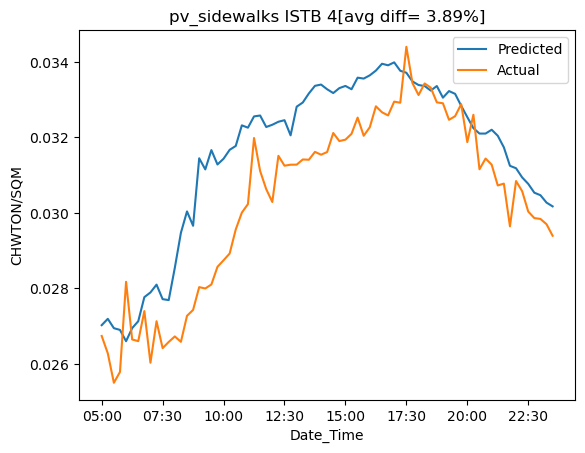

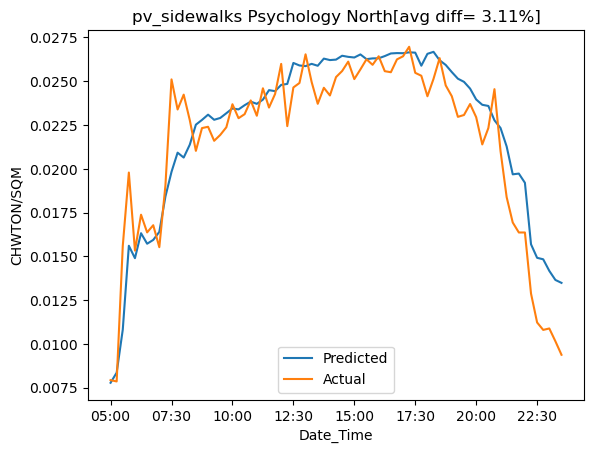

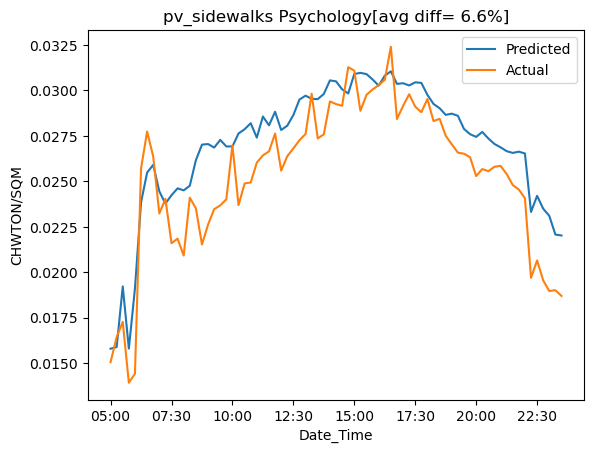

In [36]:
df_combined, df_bldgs = data_obj.create_df_bldgs_input(y_scenario,
                                                       y_actual,
                                                       three_bldgs_actual_df)


# # 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 scenario_name, 
                 output_path=f"{config.RESULT_DIR_PATH}/{MODEL_NAME}", 
                 is_save=True)